In [169]:
import torch
from torch.distributions import Normal, Independent, Categorical, MixtureSameFamily
import matplotlib.pyplot as plt

from pyro.distributions.transforms import affine_autoregressive, ComposeTransformModule, Permute,spline_autoregressive
from pyro.distributions import TransformedDistribution

from copy import deepcopy

In [170]:
from sbi.vi.build_q import build_flow

In [239]:
q = build_flow(2, flow_block="spline_autoregressive")

In [240]:
q_surrogate = deepcopy(q)

In [241]:
samples = q.rsample((100,))

In [174]:
def _inv_call(self, y):
        """
        Inverts the transform `y => x`.
        Also caches if not at the same memory address but equivalent
        """
        if self._cache_size == 0:
            return self._inverse(y)
        x_old, y_old = self._cached_x_y
        if torch.all((y == y_old)):
            return x_old
        x = self._inverse(y)
        self._cached_x_y = x, y
        return x

In [175]:
import types
# This allows chaching also for "detached" samples...
for t in q.transforms:
    t._inv_call = types.MethodType(_inv_call, t)

In [176]:
%%timeit
q.log_prob(samples.detach())

552 µs ± 7.72 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [268]:
#%%timeit
samples2 = samples
elbo = torch.mean(q.log_prob(samples2)) - torch.mean(q.log_prob(samples2.detach()))
torch.autograd.grad(elbo, q.parameters(), retain_graph=True)[0]


tensor([[-0.0053,  0.0000],
        [ 0.0425,  0.0000],
        [-0.0590,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.0191,  0.0000],
        [ 0.0062,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0688,  0.0000],
        [ 0.0623,  0.0000],
        [-0.0138,  0.0000],
        [-0.0749,  0.0000],
        [-0.0384,  0.0000],
        [-0.0037,  0.0000],
        [ 0.0754,  0.0000]])

In [262]:
def set_requires_grad(q, val):
    for para in q.parameters():
        para.requires_grad=val

In [269]:
#%%timeit
samples2 = samples
set_requires_grad(q,False)
logq = q.log_prob(samples2)
set_requires_grad(q,True)
elbo = torch.mean(logq) 
torch.autograd.grad(elbo, q.parameters(), retain_graph=True)[0]

tensor([[-0.0053,  0.0000],
        [ 0.0425,  0.0000],
        [-0.0590,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.0191, -0.0000],
        [ 0.0062,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0688,  0.0000],
        [ 0.0623,  0.0000],
        [-0.0138, -0.0000],
        [-0.0749, -0.0000],
        [-0.0384, -0.0000],
        [-0.0037,  0.0000],
        [ 0.0754, -0.0000]])

In [253]:
def update_surogate(q,q_surrogate):
    for para, new_para in zip(q.parameters(), q_surrogate.parameters()):
        new_para.data = para.data.clone().detach()

In [270]:
#%%timeit
samples2 = samples
update_surogate(q, q_surrogate)
logq = q_surrogate.log_prob(samples2)
elbo = torch.mean(logq)
torch.autograd.grad(elbo, q.parameters(), retain_graph=True)[0]

tensor([[-0.0053,  0.0000],
        [ 0.0425,  0.0000],
        [-0.0590,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.0191, -0.0000],
        [ 0.0062,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0688,  0.0000],
        [ 0.0623,  0.0000],
        [-0.0138, -0.0000],
        [-0.0749, -0.0000],
        [-0.0384, -0.0000],
        [-0.0037,  0.0000],
        [ 0.0754, -0.0000]])

In [325]:
q1 = build_flow(2)
q_surrogate = deepcopy(q1)

In [326]:
comp = Independent(Normal(torch.tensor([[4.,0.], [4.,0.]]), torch.ones(2)),1)
mix = Categorical(torch.ones(2))
p = MixtureSameFamily(mix, comp)

In [327]:
optimizer = torch.optim.Adam(q1.parameters())
n_particles = 1
K = 128
losses1 = []
for i in range(2000):
    optimizer.zero_grad()
    samples = q1.rsample((n_particles,K))
    log_q = q1.log_prob(samples)
    log_p = p.log_prob(samples)
    loss = -torch.mean(torch.exp(log_p-log_q), 1).log().mean()
    #loss = -torch.mean(log_p-log_q)
    loss.backward()
    optimizer.step()
    losses1.append(loss.detach())

In [355]:
q2 = build_flow(2)
q_surrogate = deepcopy(q2)

# Control variates

Control variates are a general method to reduce the variance of a stochastic estimator. Its a function $c(b)$ with known expectation $E[c(b)]$. Given any estimator $g(b)$, then the estiamtor 
$$ \hat{g}(b) = g(B) - c(b) + E[c(b)]$$
Is a new uunbiased estimator, but has lower variance if $c(b)$ is positively correlated with $\hat{g}$...

In [356]:
optimizer = torch.optim.Adam(q2.parameters())
losses2 = []
for i in range(2000):
    optimizer.zero_grad()
    #base_line_opt.zero_grad()
    samples = q2.rsample((n_particles,K))
    #b = base_line(samples.detach())
    #samples.requires_grad=True
    #log_q = q2.log_prob(samples)
   # update_surogate(q2,q_surrogate)
    #log_q = q_surrogate.log_prob(samples)
    set_requires_grad(q2,False)
    logq = q2.log_prob(samples)
    #set_requires_grad(q2,True)
    #log_q = q2.log_prob(samples) - q2.log_prob(samples.detach())
    # Average baseline
    #beta = sum(losses2[-50:])/50
    #set_requires_grad(q2, False)
    #set_requires_grad(q2, True)
    log_p = p.log_prob(samples)
    elbo = log_p - log_q
    weights = elbo.clone().detach()
    normed_weights = torch.exp(weights- torch.logsumexp(weights,1).unsqueeze(-1))
    loss = -torch.sum(normed_weights*elbo,1).mean()
    #loss = -torch.mean(torch.exp(log_p-log_q),1).log().mean()
    #f = log_q - log_p
    #base_line_loss = (f.detach()-b)**2
    #base_line_loss.backward()
    #loss = f + (f.detach()-b.detach())*q2.log_prob(samples.detach())
    #set_requires_grad(q2, True)
    loss.backward(retain_graph=True)
    optimizer.step()
    #base_line_opt.step()
    loss = -torch.mean(torch.exp(log_p-log_q),1).log().mean()
    losses2.append(loss.detach())

RuntimeError: Trying to backward through the graph a second time (or directly access saved variables after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved variables after calling backward.

In [330]:
q3 = build_flow(2)
q_surrogate = deepcopy(q3)

In [331]:
optimizer = torch.optim.Adam(q3.parameters())
losses3 = []
for i in range(2000):
    optimizer.zero_grad()
    samples = q3.rsample((n_particles,K))
    update_surogate(q3,q_surrogate)
    log_q = q_surrogate.log_prob(samples)
    log_p = p.log_prob(samples)

    elbo = log_p - log_q
    with torch.no_grad():
        weights = torch.exp(elbo - torch.logsumexp(elbo,1))
        elbo.register_hook(lambda grad: weights*grad)
    
    #weights = elbo.clone().detach()
    #normed_weights = torch.exp(weights- torch.logsumexp(weights,1).unsqueeze(-1))

    loss = -torch.sum(weights*elbo).sum(-1).mean(-1)
    loss.backward()
    real_loss =-torch.mean(torch.exp(log_p-log_q),1).log().mean()
    optimizer.step()
    losses3.append(real_loss.detach())

(-4.0, 4.0)

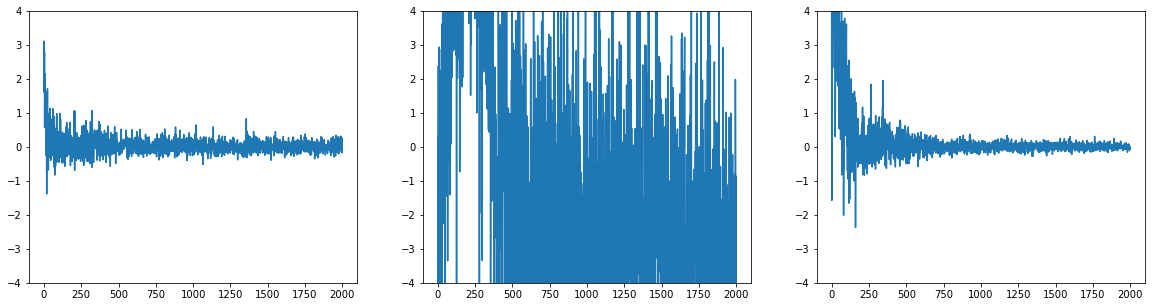

In [349]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
    
axs[0].plot(losses1)
axs[1].plot(losses2)
axs[2].plot(losses3)
axs[0].set_ylim(-4,4)
axs[1].set_ylim(-4,4)
axs[2].set_ylim(-4,4)

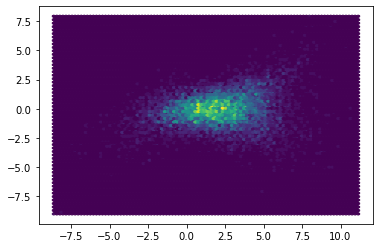

In [344]:
samples = q1.sample((10000,))
plt.hexbin(samples[:,0], samples[:,1])

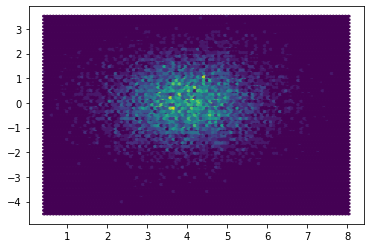

In [345]:
samples = q2.sample((10000,))
plt.hexbin(samples[:,0], samples[:,1])

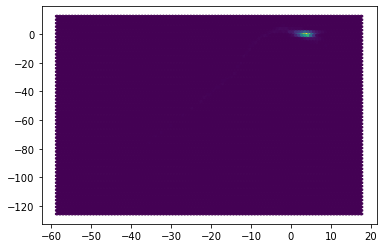

In [336]:
samples = q3.sample((10000,))
plt.hexbin(samples[:,0], samples[:,1])

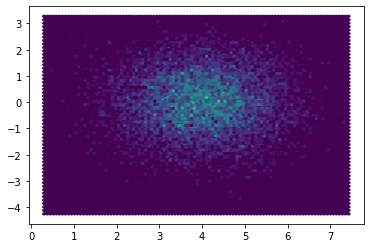

In [284]:
samples = p.sample((10000,))
plt.hexbin(samples[:,0], samples[:,1])